# Train vs. Test dataset distributions

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', UserWarning)

In [3]:
import sys
sys.path.insert(0, '/home/ektov-av/python35-libs/lib/python3.5/site-packages/') 

import gc, os
import itertools
from copy import deepcopy

import numpy as np
import pandas as pd

from tqdm import tqdm

from scipy.stats import ks_2samp

from sklearn.externals import joblib
from sklearn.preprocessing import scale, MinMaxScaler, Imputer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

from sklearn import manifold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.externals import joblib

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

from support_library.plot import Plot as mplt
from support_library.feature_eng import Featureng as fe

%matplotlib inline

In [5]:
import eli5

/opt/cloudera/parcels/PYENV.ZNO41714840/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
def get_path(folder, file):
    return os.path.join(folder, file)

# 1. t-SNE Distribution Overview
scaling all the data with mean-variance, but for columns where we have outliers (> 3x standard deviation) do a log-transform prior to scaling.

## 1.0. Data Pre-Processing
Current pre-processing procedure:
* Get rows from training set and test set and concatenate them
* Columns with standard deviation of 0 in training set removed
* Columns which are duplicate in training set removed
* Log-transform all columns which have significant outliers (> 3x standard deviation)
* Create datasets with: 
    * Mean-variance scale all columns including 0-values!
    * Mean-variance scale all columns **excluding** 0-values!
    

In [5]:
top_corr_features = pd.read_pickle('pkl_store/top_corr_features_le_all.pkl')

In [6]:
le=joblib.load(get_path('pkl_store', 'label_encoders_trn.pkl'))
cat_features=list(set(le.keys()))

In [7]:
# define base features to calculate polynomial features interactions 
cattopoly=[ 'product_avg_mean',
            'product_avg_std',
            'product_group_avg_mean',
            'product_group_avg_std',
            'gosb_avg_mean',
            'gosb_avg_std',
            'tb_avg_mean',
            'tb_avg_std',
            'priority_client_avg_mean',
            'priority_client_avg_std',
            'days_between_km_dealdiff',
            'sum_sold_total_cumulate_km_shift_3'
] 

In [8]:
# How many samples to take from both train and test
SAMPLE_SIZE_TRN = 445512
SAMPLE_SIZE_TST = 19860
target_column='is_sold'

In [9]:
# Read train and test files
train_df = pd.read_pickle('pkl_store/total_dataset_unencoded.pkl').sample(SAMPLE_SIZE_TRN)
X_test   = pd.read_pickle('pkl_store/test_dataset_unencoded.pkl').sample(SAMPLE_SIZE_TST)

In [10]:
X_train, y_train = train_df.drop(target_column, axis = 1), train_df[target_column]

In [11]:
X_trn, X_tst = fe.features_endineering( X_train, X_test, 
                                        y_train, 
                                        cat_features, 
                                        cattopoly, 
                                        save_dict=False )

/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:203: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  NaN
New labels:  NaN
New labels:  GM. FX OPTION, Гарантии исполнения финансовых обязательств по кредитному договору


In [12]:
imp=Imputer(missing_values='NaN', strategy='median', axis=1)

In [13]:
X_trn=pd.DataFrame(imp.transform(X_trn), columns=X_trn.columns)
X_tst=pd.DataFrame(imp.transform(X_tst), columns=X_tst.columns)

In [14]:
# Get the combined data
total_df = pd.concat([X_trn, X_tst], axis=0, sort=False)

In [15]:
total_df.reset_index(inplace=True)

In [16]:
total_df.drop(['index'], axis=1, inplace=True)

In [17]:
total_df.head()

,tb,gosb,product,product_group,days_cr_q_end,segment_client,priority_client,sum_sold,sum_sold_cumulate,sum_refused,...,tb_avg_std priority_client_avg_mean priority_client_avg_std,tb_avg_std priority_client_avg_mean days_between_km_dealdiff,tb_avg_std priority_client_avg_mean sum_sold_total_cumulate_km_shift_3,tb_avg_std priority_client_avg_std days_between_km_dealdiff,tb_avg_std priority_client_avg_std sum_sold_total_cumulate_km_shift_3,tb_avg_std days_between_km_dealdiff sum_sold_total_cumulate_km_shift_3,priority_client_avg_mean priority_client_avg_std days_between_km_dealdiff,priority_client_avg_mean priority_client_avg_std sum_sold_total_cumulate_km_shift_3,priority_client_avg_mean days_between_km_dealdiff sum_sold_total_cumulate_km_shift_3,priority_client_avg_std days_between_km_dealdiff sum_sold_total_cumulate_km_shift_3
0,7.0,20.0,35.0,3.0,38.0,1.0,10.0,0.0,2.0,0.0,...,0.142314,2.636925,0.000000,1.737257,0.000000,0.000000,2.713386,0.000000,0.000000,0.000000
1,2.0,21.0,2.0,20.0,38.0,1.0,10.0,0.0,5.0,0.0,...,0.137104,2.538662,11.053018,1.667663,7.260797,134.443005,2.724996,11.864292,219.682654,144.310916
2,13.0,38.0,55.0,13.0,39.0,1.0,8.0,0.0,0.0,0.0,...,0.144851,0.303367,1.516833,0.215528,1.077641,2.256938,0.320902,1.604510,3.360377,2.387396
3,5.0,46.0,89.0,25.0,16.0,1.0,9.0,0.0,4.0,0.0,...,0.139403,2.918263,8.928369,1.505981,4.607519,96.453690,2.713805,8.302833,173.811295,89.695997
4,5.0,46.0,35.0,3.0,29.0,1.0,10.0,4.0,4.0,0.0,...,0.140458,0.301486,3.316343,0.203941,2.243353,4.815243,0.320864,3.529500,7.575894,5.124742


In [14]:
# total_df.fillna(total_df.mean(), inplace=True)

In [18]:
np.where(total_df.isnull().sum().values)

(array([], dtype=int64),)

In [19]:
%%time 

# Columns to drop because there is no variation in training set
zero_std_cols = total_df.columns[total_df.std() == 0]
total_df.drop(zero_std_cols, axis=1, inplace=True)
print('Removed {} constant columns'.format(len(zero_std_cols)))

# Removing duplicate columns

# colsToRemove = []
# colsScaned = []
# dupList = {}
# columns = total_df.columns
# for i in range(len(columns)-1):
#     v = total_df[columns[i]].values
#     dupCols = []
#     for j in range(i+1,len(columns)):
#         if np.array_equal(v, total_df[columns[j]].values):
#             colsToRemove.append(columns[j])
#             if columns[j] not in colsScaned:
#                 dupCols.append(columns[j]) 
#                 colsScaned.append(columns[j])
#                 dupList[columns[i]] = dupCols
# colsToRemove = list(set(colsToRemove))
# total_df.drop(colsToRemove, axis=1, inplace=True)
# print('Dropped {} duplicate columns'.format(len(colsToRemove)))

# Go through the columns one at a time (can't do it all at once for this dataset)
total_df_all = total_df.copy()
for col in total_df.columns:
    
    # Detect outliers in this column
    data = total_df[col].values.copy()
    data_mean, data_std = np.mean(data), np.std(data, ddof=0)
    #print('{} --> mean: {} std: {}'.format(col, data_mean, data_std))
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    
    # If there are crazy high values, do a log-transform
    if len(outliers) > 0:
        non_zero_idx = (data != 0) & (data > 0) 
        total_df.loc[non_zero_idx, col] = np.log(data[non_zero_idx])
        total_df.replace({col: {np.inf: 0, -np.inf: 0}}, inplace=True)

        total_df_all.loc[non_zero_idx, col] = np.log(data[non_zero_idx])
        total_df_all.replace({col: {np.inf: 0, -np.inf: 0}}, inplace=True)        
        
    # Scale non-zero column values
    nonzero_rows = total_df[col] != 0
    total_df.loc[nonzero_rows, col] = scale(total_df.loc[nonzero_rows, col])
    
    # Scale all column values
    total_df_all.loc[:, col] = scale(total_df_all.loc[:, col])
    gc.collect()
    
       
# Train and test
train_idx = range(0, len(train_df))
test_idx = range(len(train_df), len(total_df))

Removed 0 constant columns
CPU times: user 1min 45s, sys: 7.44 s, total: 1min 52s
Wall time: 1min 52s


In [20]:
np.where(total_df.isnull().sum().values)

(array([], dtype=int64),)

## 1.1. Performing PCA
perform PCA prior to the t-SNE to reduce the dimensionality a bit.
include 100 PCA components, which includes about 80% of the variation in the dataset, which I think it allright for saying something about the distributions, but also speeding up t-SNE a bit.

In [21]:
def test_pca(data, create_plots=True):
    """Run PCA analysis, return embedding"""
    
    # Create a PCA object, specifying how many components we wish to keep
    pca = PCA(n_components=50)

    # Run PCA on scaled numeric dataframe, and retrieve the projected data
    pca_trafo = pca.fit_transform(data)    

    # The transformed data is in a numpy matrix. This may be inconvenient if we want to further
    # process the data, and have a more visual impression of what each column is etc. We therefore
    # put transformed/projected data into new dataframe, where we specify column names and index
    pca_df = pd.DataFrame(
        pca_trafo,
        index=total_df.index,
        columns=["PC" + str(i + 1) for i in range(pca_trafo.shape[1])]
    )

    # Only construct plots if requested
    if create_plots:
        
        # Create two plots next to each other
        _, axes = plt.subplots(2, 2, figsize=(20, 15))
        axes = list(itertools.chain.from_iterable(axes))

        # Plot the explained variance# Plot t 
        axes[0].plot(
            pca.explained_variance_ratio_, "--o", linewidth=2,
            label="Explained variance ratio"
        )

        # Plot the cumulative explained variance
        axes[0].plot(
            pca.explained_variance_ratio_.cumsum(), "--o", linewidth=2,
            label="Cumulative explained variance ratio"
        )

        # Show legend
        axes[0].legend(loc="best", frameon=True)

        # Show biplots
        for i in range(1, 4):

            # Components to be plottet
            x, y = "PC"+str(i), "PC"+str(i+1)

            # Plot biplots
            settings = {'kind': 'scatter', 'ax': axes[i], 'alpha': 0.2, 'x': x, 'y': y}
            pca_df.iloc[train_idx].plot(label='Train', c='#ff7f0e', **settings)
            pca_df.iloc[test_idx].plot(label='Test',  c='#1f77b4', **settings)    

        # Show the plot
        plt.show()
    
    return pca_df

## Run the PCA and get the embedded dimension (Scale non-zero column values)

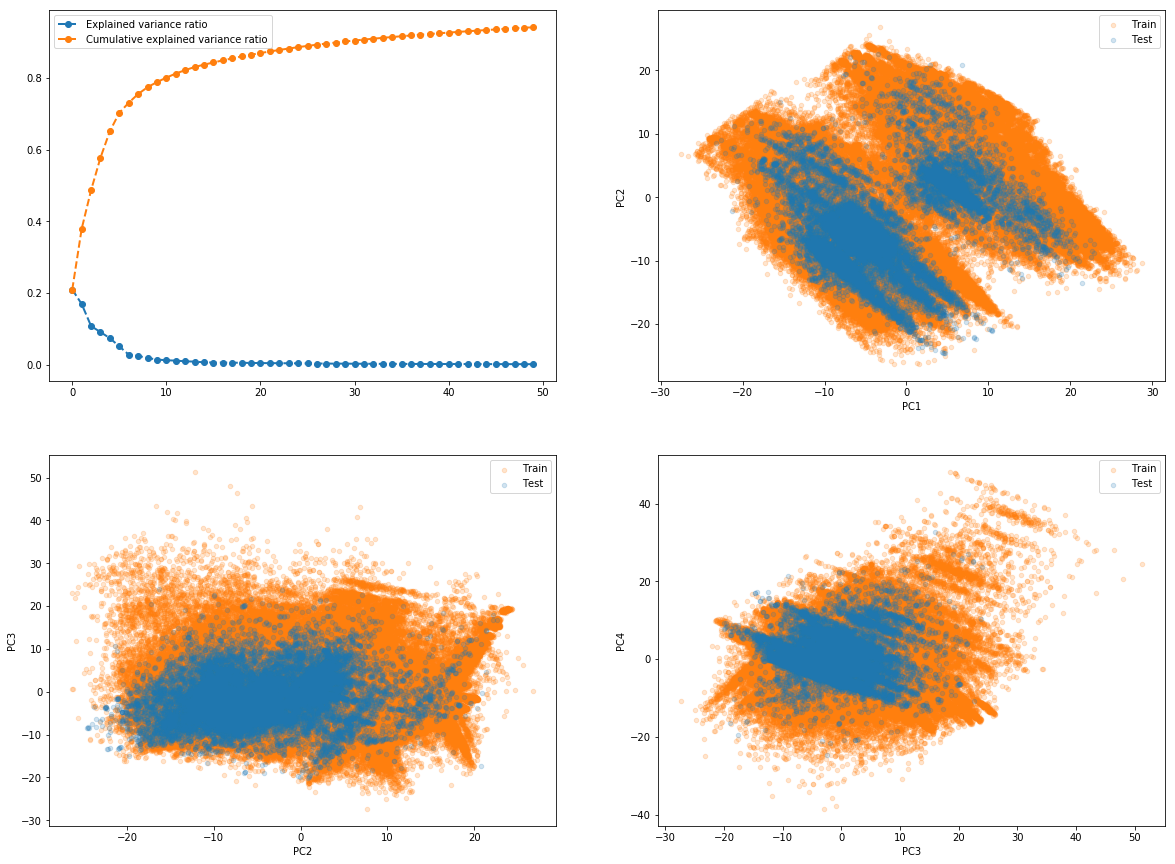

In [86]:
pca_df = test_pca(total_df)

## Run the PCA and get the embedded dimension (Scale all column values)

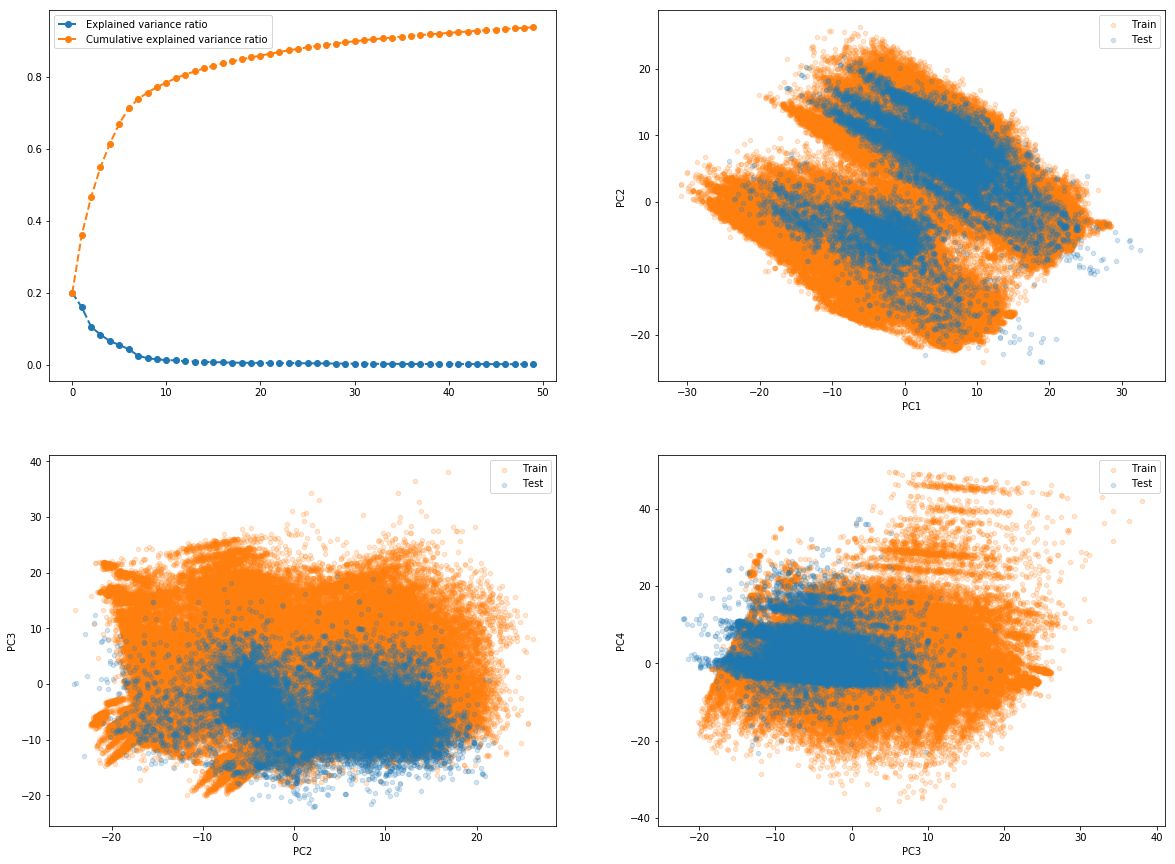

In [87]:
pca_df_all = test_pca(total_df_all, create_plots=True)



## 1.2. Running t-SNE
run the t-SNE and subsequently plot both training and test data in the embedded 2D space.

In [6]:
def test_tsne(data, ax=None, title='t-SNE'):
    """Run t-SNE and return embedding"""

    # Run t-SNE
    tsne = TSNE(n_components=2, init='pca')
    Y = tsne.fit_transform(data)

    # Create plot
    for name, idx in zip(["Train", "Test"], [train_idx, test_idx]):
        ax.scatter(Y[idx, 0], Y[idx, 1], label=name, alpha=0.2)
        ax.set_title(title)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
    ax.legend()        
    return Y 

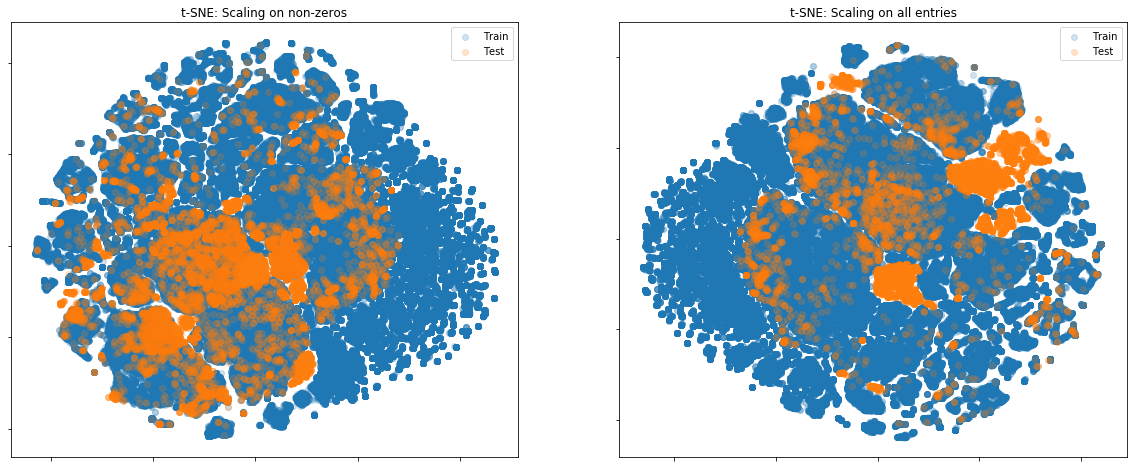

In [89]:
# Run t-SNE on PCA embedding
_, axes = plt.subplots(1, 2, figsize=(20, 8))

tsne_df = test_tsne(
    pca_df, axes[0],
    title='t-SNE: Scaling on non-zeros'
)
tsne_df_unique = test_tsne(
    pca_df_all, axes[1],
    title='t-SNE: Scaling on all entries'
)

plt.axis('tight')
plt.show() 

From this is seems like if scaling is performed both on non-zero entries and on all entries, then the training and test set looks more similar (they aren't too separated from each other in both cases). 

### 1.2.1. t-SNE colored by row-index or zero-count
data is time separated, so it'd be interesting to look a bit more into why the t-SNE looks as it does. The two most obvious measures to investigate, that I could come up with off the top of my head, were the index of the rows (as a measure of 'time', assuming data is not shuffled), and the number of zeros for the given rows.

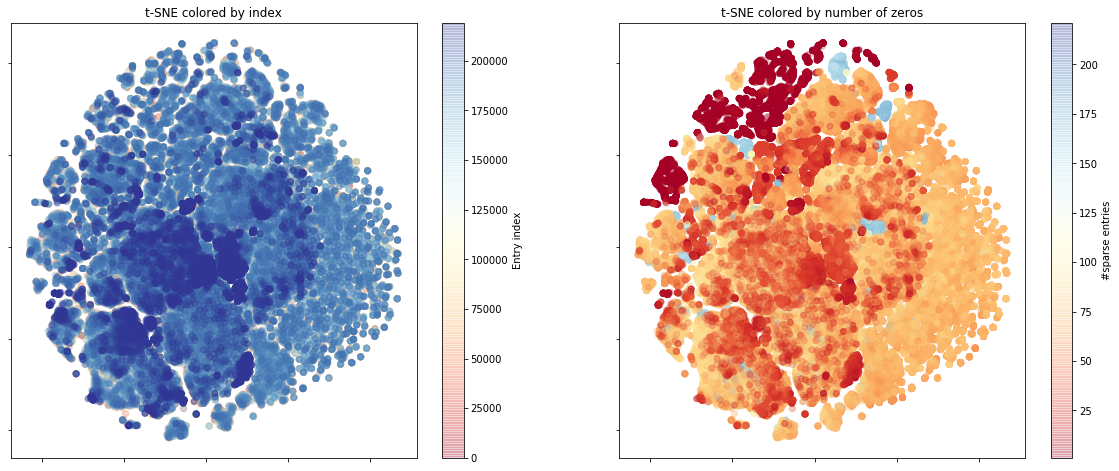

In [ ]:
gc.collect()
# Get our color map
cm = plt.cm.get_cmap('RdYlBu')

# Create plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sc = axes[0].scatter(tsne_df[:, 0], tsne_df[:, 1], alpha=0.2, c=range(len(tsne_df)), cmap=cm)
cbar = fig.colorbar(sc, ax=axes[0])
cbar.set_label('Entry index')
axes[0].set_title("t-SNE colored by index")
axes[0].xaxis.set_major_formatter(NullFormatter())
axes[0].yaxis.set_major_formatter(NullFormatter())

zero_count = (total_df == 0).sum(axis=1).values
sc = axes[1].scatter(tsne_df[:, 0], tsne_df[:, 1], alpha=0.2, c=zero_count, cmap=cm)
cbar = fig.colorbar(sc, ax=axes[1])
cbar.set_label('#sparse entries')
axes[1].set_title("t-SNE colored by number of zeros")
axes[1].xaxis.set_major_formatter(NullFormatter())
axes[1].yaxis.set_major_formatter(NullFormatter())
 

Looks pretty interesting - seems like the higher-index rows are located more at the center of the plot. Also, we see a small cluster of rows with few zero-entries, as well as a few more clusters in the right-hand figure.

### 1.2.2. t-SNE with different perplexities
t-SNE can give some pretty tricky to intepret results depending on the perplexity parameter used. So just to be sure in the following I check for a few different values of the perplexity parameter.

In [ ]:
_, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, perplexity in enumerate([5, 30, 50, 100]):
    
    # Create projection
    Y = TSNE(init='pca', perplexity=perplexity).fit_transform(pca_df)
    
    # Plot t-SNE
    for name, idx in zip(["Train", "Test"], [train_idx, test_idx]):
        axes[i].scatter(Y[idx, 0], Y[idx, 1], label=name, alpha=0.2)
    axes[i].set_title("Perplexity=%d" % perplexity)
    axes[i].xaxis.set_major_formatter(NullFormatter())
    axes[i].yaxis.set_major_formatter(NullFormatter())
    axes[i].legend() 

plt.show()

Overall these all look pretty similar and show the same trend, so no need to worry about the perplexity parameter it seems.

### 1.2.3. t-SNE colored by target
For the training set it may be interesting to see how the different target values are separated on the embedded two dimensions.

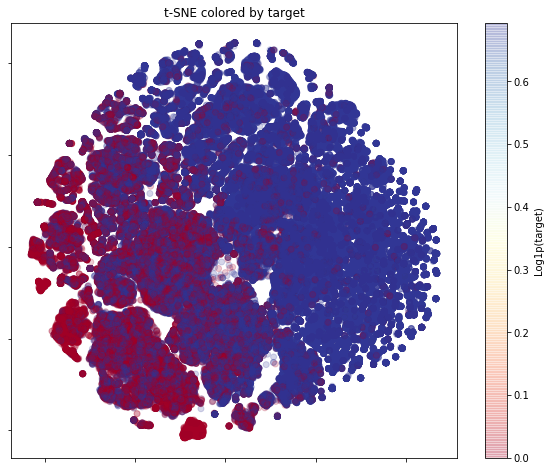

In [97]:
# Create plot
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sc = axes.scatter(tsne_df[train_idx, 0], tsne_df[train_idx, 1], alpha=0.2, 
                  c=np.log1p(train_df[target_column].values), cmap=cm)
cbar = fig.colorbar(sc, ax=axes)
cbar.set_label('Log1p(target)')
axes.set_title("t-SNE colored by target")
axes.xaxis.set_major_formatter(NullFormatter())
axes.yaxis.set_major_formatter(NullFormatter())

Clearly the different train target values are located at different locations in the t-SNE plot.

# 2. Classification of Test vs. Train
Another good check is to see how well we can classify whether a given entry belongs to test or training dataset - if it is possible to do this reasonably well, that is an indication of differences between the two dataset distributions. I'll just run a simple shuffled 10-fold cross-validation with a basic random forest model to see how well it performs this task. First let's try that classification on the case where scaling is performed on all entries:

In [7]:
def test_prediction(data):
    """Try to classify train/test samples from total dataframe"""

    # Create a target which is 1 for training rows, 0 for test rows
    y = np.zeros(len(data))
    y[train_idx] = 1

    # Perform shuffled CV predictions of train/test label
    predictions = cross_val_predict(
        ExtraTreesClassifier(n_estimators=3000, n_jobs=-1),
        data, y,
        cv=StratifiedKFold(
            n_splits=4,
            shuffle=True,
            random_state=42
        )
    )

    # Show the classification report
    print(classification_report(y, predictions))
    

In [ ]:
# Run classification on total raw data
test_prediction(total_df_all)

In [102]:
test_prediction(total_df)

             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99     19000
        1.0       1.00      1.00      1.00    200000

avg / total       1.00      1.00      1.00    219000



f1 score is equal to 0.99 in both cases; corresponding to what we observed in the t-SNE analysis, but still it's apparently quite easy for the model to decently well distinguish between train and test - considering the very simple classifcation model used here.

# 3. Feature-by-feature distribution similarity
Next let us try to look at the problem feature-by-feature, and perform Kolmogorov-Smirnov tests to see if the distribution in test and training set is similar.
* use the function [scipy.stats.ks_2samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp) from scipy to run the tests.

For all those features where the distributions are highly distinguishable, we may benefit from ignoring those columns, so as to avoid overfitting on training data. In the following just identify those columns, and plot the distributions as a sanity check for some of the features

In [8]:
def get_diff_columns(train_df, test_df, show_plots=True, show_all=False, threshold=0.1, kde=False):
    """Use KS to estimate columns where distributions differ a lot from each other"""

    # Find the columns where the distributions are very different
    diff_data = []
    for col in tqdm(train_df.columns):
        statistic, pvalue = ks_2samp(
            train_df[col].values, 
            test_df[col].values
        )
        if pvalue <= 0.05 and np.abs(statistic) >= threshold:
            diff_data.append({'feature': col, 'p': np.round(pvalue, 5), 'statistic': np.round(np.abs(statistic), 3)})

    # Put the differences into a dataframe
    diff_df = pd.DataFrame(diff_data)
    diff_df.sort_values(by='statistic', ascending=False, inplace=True)
    
    if show_plots:
        # Let us see the distributions of these columns to confirm they are indeed different
        n_cols = 3
        if show_all:
            n_rows = int(len(diff_df) / 3)
        else:
            n_rows = 7
        _, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
        axes = [x for l in axes for x in l]

        # Create plots
        for i, (_, row) in enumerate(diff_df.iterrows()):
            if i >= len(axes):
                break
            if not kde:    
                extreme = np.max(np.abs(train_df[row.feature].tolist() + test_df[row.feature].tolist()))
                train_df.loc[:, row.feature].hist(
                    ax=axes[i], alpha=0.5, label='Train', density=True,
                    bins=np.arange(-extreme, extreme, 0.05)
                )
                test_df.loc[:, row.feature].hist(
                    ax=axes[i], alpha=0.5, label='Test', density=True,
                    bins=np.arange(-extreme, extreme, 0.05)
                )
                axes[i].legend()
            else:
                sns.distplot(train_df.loc[:, row.feature], label='Train', 
                             hist=False, kde=True, norm_hist=True, ax=axes[i])
                sns.distplot(test_df.loc[:, row.feature], label='Test', 
                             hist=False, kde=True, norm_hist=True, ax=axes[i])
                
            axes[i].set_title('Statistic = {}, p = {}'.format(row.statistic, row.p))
            axes[i].set_xlabel('{}'.format(row.feature))
            

        plt.tight_layout()
        plt.show()
        
    return diff_df

100%|██████████| 578/578 [00:35<00:00, 16.45it/s]
/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


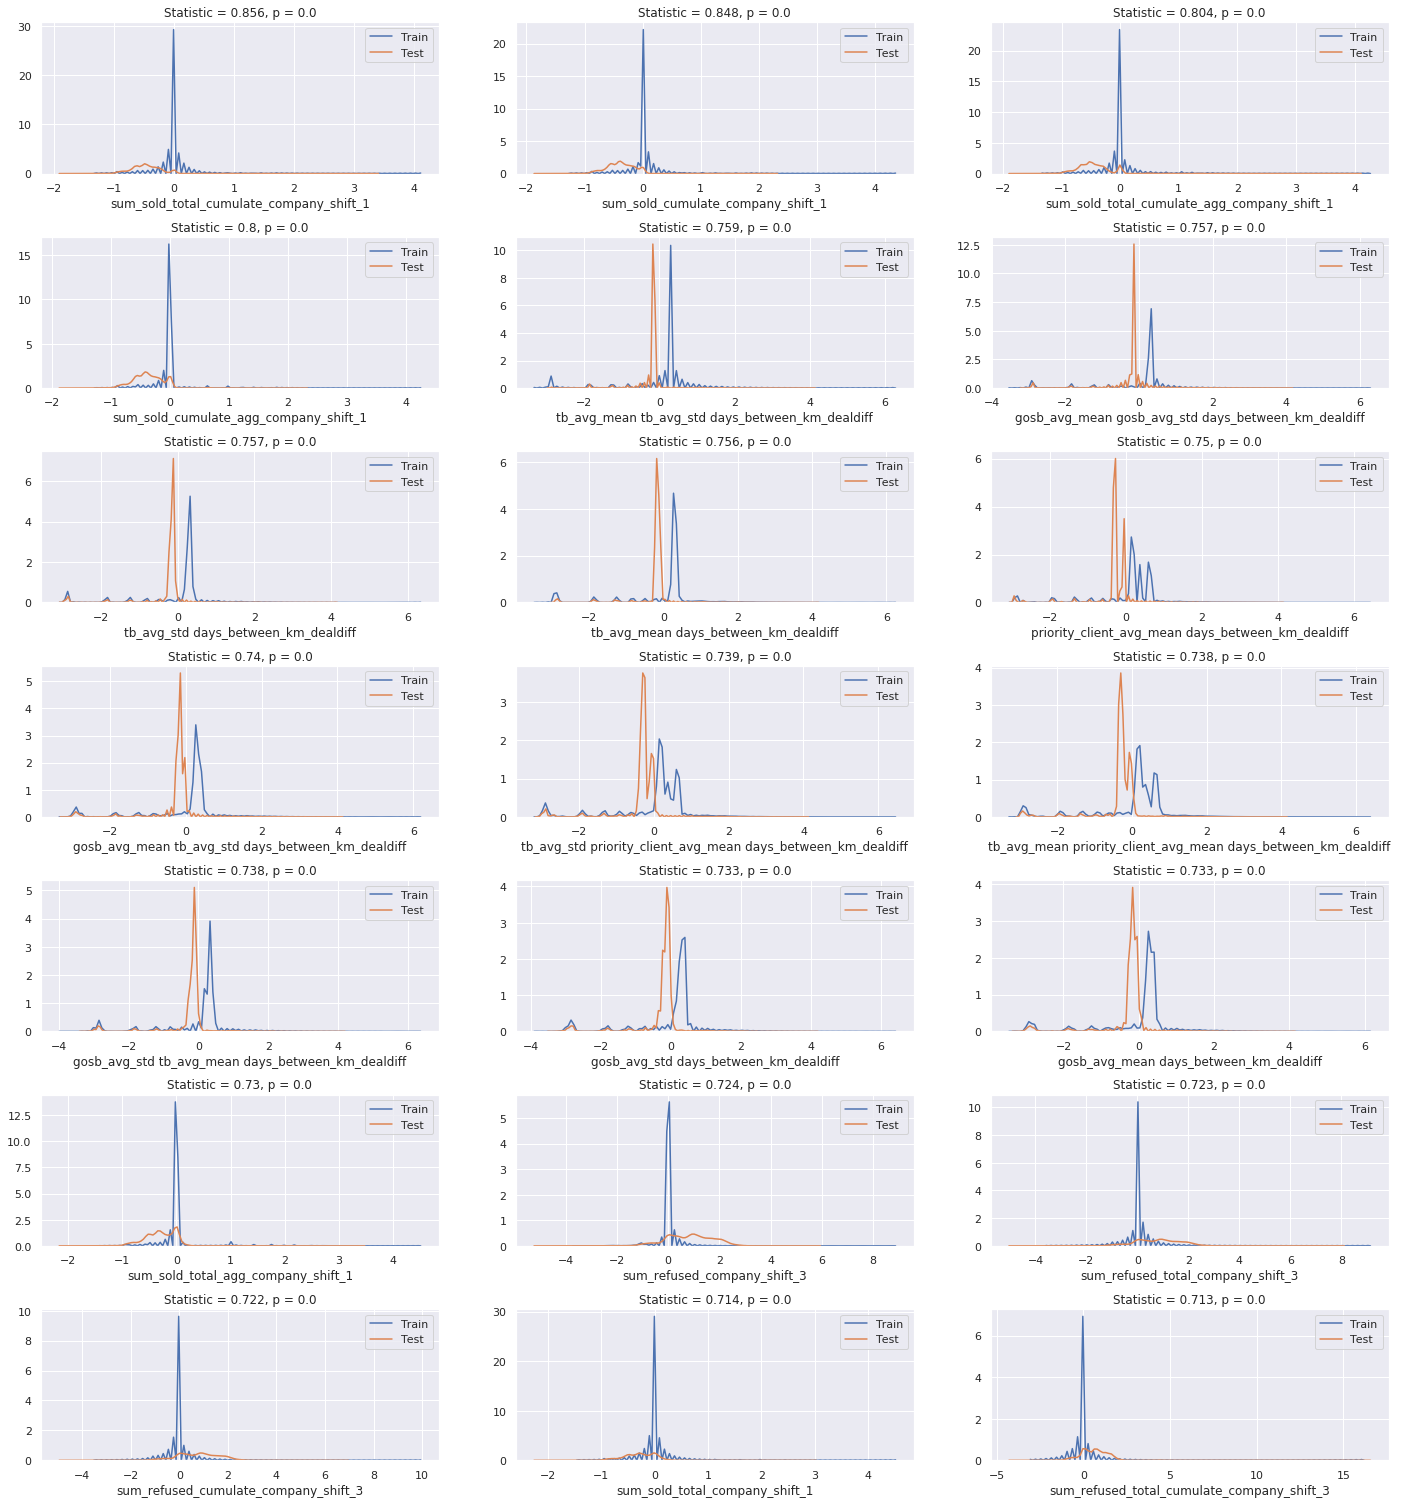

In [25]:
# Get the columns which differ a lot between test and train
diff_df = get_diff_columns(total_df.iloc[train_idx], total_df.iloc[test_idx], threshold=0.4, kde=True)

In [27]:
total_df.shape[1], diff_df.shape[0]

(578, 106)

On my run it dropped about 100 features. Let's try a classification report again to see if we can distinguish test from train.

In [155]:
# Run classification on total raw data
print('Dropping {} features based on KS tests'.format(len(diff_df)))
test_prediction(
    total_df.drop(diff_df.feature.values, axis=1)
)

Dropping 192 features based on KS tests
             precision    recall  f1-score   support

        0.0       0.96      0.79      0.87     19000
        1.0       0.98      1.00      0.99    200000

avg / total       0.98      0.98      0.98    219000




# 4. Decomposition Feature



In [28]:
COMPONENTS = 50

# List of decomposition methods to use
methods = [
    TruncatedSVD(n_components=COMPONENTS),
    PCA(n_components=COMPONENTS),
    FastICA(n_components=COMPONENTS),
    GaussianRandomProjection(n_components=COMPONENTS, eps=0.1),
    SparseRandomProjection(n_components=COMPONENTS, dense_output=True)    
]

# Run all the methods
embeddings = []
for method in tqdm(methods):
    name = method.__class__.__name__    
    embeddings.append(
        pd.DataFrame(method.fit_transform(total_df), columns=['{}_{}'.format(name,i) for i in range(COMPONENTS)])
    )
    print('Ran {}'.format(name))
    
# Put all components into one dataframe
components_df = pd.concat(embeddings, axis=1)

 20%|██        | 1/5 [00:16<01:05, 16.35s/it]

Ran TruncatedSVD


 40%|████      | 2/5 [00:39<00:59, 19.94s/it]

Ran PCA


 60%|██████    | 3/5 [06:49<04:33, 136.66s/it]

Ran FastICA


 80%|████████  | 4/5 [06:50<01:42, 102.63s/it]

Ran GaussianRandomProjection


100%|██████████| 5/5 [06:51<00:00, 82.32s/it] 

Ran SparseRandomProjection


In [10]:
components_df.shape

(465372, 250)

In [32]:
joblib.dump(components_df, get_path('pkl_store', 'PCA_components_df.pkl'))

['pkl_store/PCA_components_df.pkl']

In [9]:
components_df=joblib.load(get_path('pkl_store', 'PCA_components_df.pkl'))

In [ ]:
# Prepare plot
_, axes = plt.subplots(1, 3, figsize=(20, 7))
cm = plt.cm.get_cmap('RdYlBu')

# Run t-SNE on components
tsne_df = test_tsne(
    components_df, axes[0],
    title='t-SNE: with decomposition features'
)

# Color by index
sc = axes[1].scatter(tsne_df[:, 0], tsne_df[:, 1], alpha=0.2, c=range(len(tsne_df)), cmap=cm)
cbar = fig.colorbar(sc, ax=axes[1])
cbar.set_label('Entry index')
axes[1].set_title("t-SNE colored by index")
axes[1].xaxis.set_major_formatter(NullFormatter())
axes[1].yaxis.set_major_formatter(NullFormatter())

# Color by target
sc = axes[2].scatter(tsne_df[train_idx, 0], tsne_df[train_idx, 1], alpha=0.2, 
                     c=np.log1p(train_df[target_column].values), cmap=cm)
cbar = fig.colorbar(sc, ax=axes[2])
cbar.set_label('Log1p(target)')
axes[2].set_title("t-SNE colored by target")
axes[2].xaxis.set_major_formatter(NullFormatter())
axes[2].yaxis.set_major_formatter(NullFormatter())

plt.axis('tight')
plt.show()  

Let us check how well we can classify train from test with these feature:

In [ ]:
test_prediction(components_df)

In [ ]:
# Get the columns which differ a lot between test and train
diff_df = get_diff_columns(
    components_df.iloc[train_idx], components_df.iloc[test_idx],
    threshold=0.2, kde=True
)

In [ ]:
# Run classification on total raw data
print('Dropping {} features based on KS tests'.format(len(diff_df)))
test_prediction(
    components_df.drop(diff_df.feature.values, axis=1)
)